In [1]:
from scipy import io
import matplotlib.pyplot as plt
import torch
import glob
import numpy as np
from SPD_DNN.spd import SPDRectified,SPDLogEig,SPDexp
import random
all_data = []
index = 1
all_label = []

batch_list = []
batch_effects = []
batch_effects =  np.random.rand(4, 32*32)
mu = [0.1+0.2*(i) for i in range(4)]
std_dev = [0.1 for i in range(4)]
batch_effects = [np.random.normal(mu[i], std_dev[i], size=(32,32)) for i in range(4)]
def SPD_plus(x1,x2):
    logeig = SPDLogEig()
    spd_exp = SPDexp()
    x1 = logeig(x1)
    x2 = logeig(x2)
    return spd_exp(x1+x2)

for index in range(1,17):
    data_dir = glob.glob('data/simulated_1/'+str(index)+'/*.mat')
    flag = 0
    for d_dir in data_dir:
        batch = (index-1)//4
        label = (index-1)%4
        if batch != 2 and label == 3:
            continue
        data = io.loadmat(d_dir)
        data = data['temp']
        data = torch.tensor(data)+1e-4*torch.eye(data.shape[-1])
        noise = torch.tensor(np.corrcoef(np.reshape(batch_effects[batch],(20,20))))+1e-6*torch.eye(data.shape[-1])
        data = SPD_plus(data, noise)
        data = data + 1e-10*torch.eye(data.shape[-1])
        batch_list.append(str(batch))
        data = torch.tensor(data)
        data += 1e-4*torch.eye(data.shape[-1])
        
        all_data.append(data.unsqueeze(0))
        all_label.append(label)
all_data = torch.cat(all_data, dim = 0)
all_data.shape

c:\Users\admin\.conda\envs\ljw\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: cannot reshape array of size 1024 into shape (20,20)

In [2]:
def log_SPD(input):
    S, U = input.symeig(eigenvectors=True)
    S = S.log().diag_embed()
    log_X = U @ S @ U.transpose(-2, -1)
    return log_X

c:\Users\admin\.conda\envs\ljw\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  


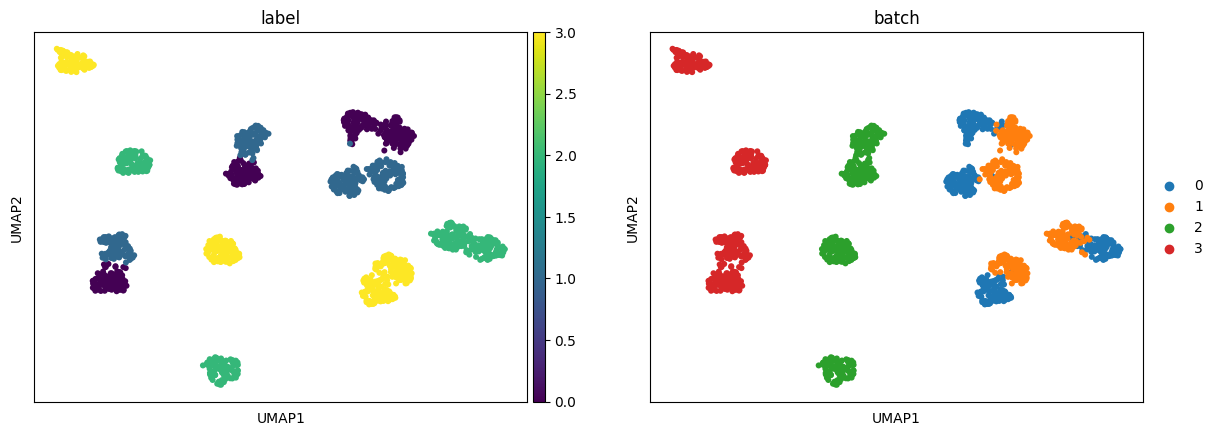

In [ ]:
import anndata
import scanpy as sc
import numpy as np
# test_data = all_data_log.reshape(len(all_data_log),264*264)
# 创建一个空的AnnData对象
# diagMatrix = all_data_SC.numpy()
all_data_log_SC = log_SPD(all_data)
# all_data_log_SC = all_data

#使用对数化后的数据来显示图像
diagMatrix = all_data_log_SC.numpy()
batch_list = np.array(batch_list)
diagMatrix = diagMatrix.reshape(len(diagMatrix),-1)
adata = anndata.AnnData(diagMatrix)
# 创建观测（样本）和变量（特征）的名称列表
obs_names = [str(i) for i in range(len(diagMatrix))]
var_names = [str(i) for i in range(diagMatrix.shape[1])]
# 创建一个随机的观测-变量矩阵
X = np.random.rand(len(obs_names), len(var_names))
# 将观测-变量矩阵和名称列表分配给AnnData对象
adata.obs_names = obs_names
adata.var_names = var_names
import pandas as pd
# pred_label_new = label_spectral
# obs_annotation = pd.DataFrame({'batch': batch_list,'label':all_label.numpy(),'global':[str(i) for i in label_spectral]})
obs_annotation = pd.DataFrame({'label':all_label,'batch':batch_list})
# obs_annotation = pd.DataFrame({'batch': batch_list,'label':all_label.numpy()})
adata.obs = obs_annotation
import scanpy as sc
sc.tl.pca(adata)
sc.pp.neighbors(adata,use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata,color=['label', 'batch'])

In [ ]:
adata.obs['celltype'] =  [str(i) for i in adata.obs['label']]
adata.obs['BATCH'] = [str(i) for i in adata.obs['batch']]

c:\Users\admin\.conda\envs\ljw\lib\site-packages\anndata\_io\h5ad.py:48: FutureWarning: The `force_dense` argument is deprecated. Use `as_dense` instead.
  FutureWarning,


c:\Users\admin\.conda\envs\ljw\lib\site-packages\sklearn\manifold\_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


purity: 0.968,NMI: 0.933.ARI: 0.945,ACC:0.384


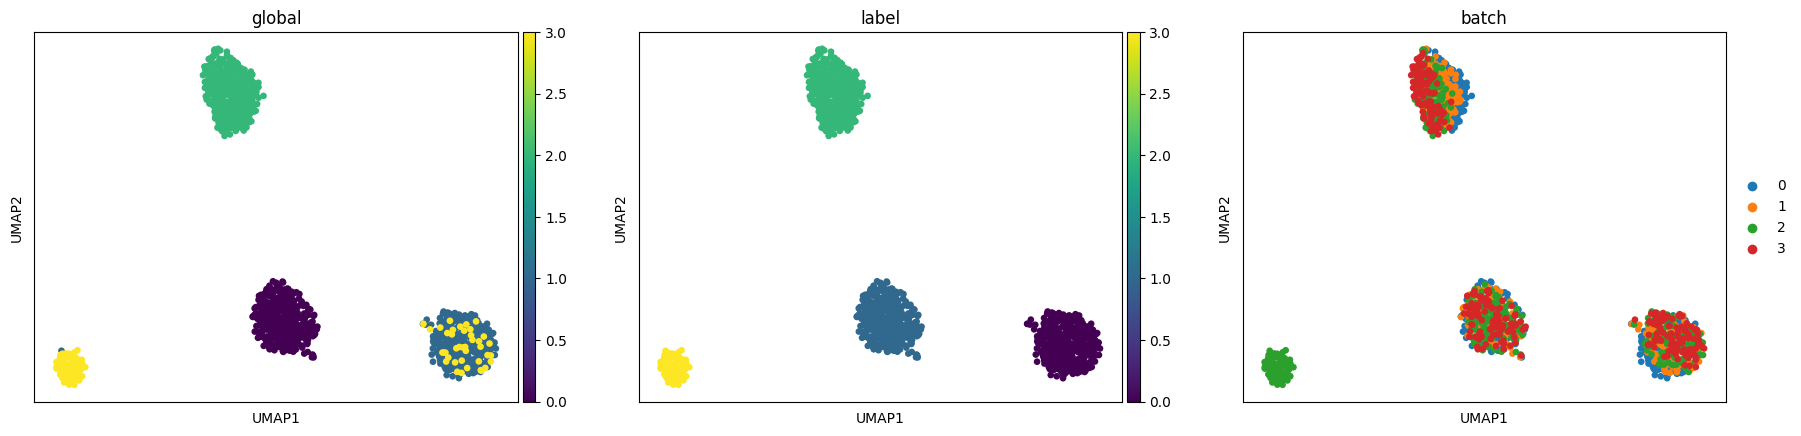

In [5]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import euclidean
# 使用流形计算方式度量
# diagMatrix = log_sc(torch.tensor(data_final))
def gaussian_distance(x1, x2):
    # 计算欧氏距离
    sigma = 4.0
    distance = euclidean(x1, x2)
    
    # 计算高斯距离
    gaussian = np.exp(-(distance ** 2) / (2 * sigma ** 2))
    
    return gaussian
diagMatrix = diagMatrix.reshape((len(diagMatrix),-1))
x_pca = adata.X
batch_list = np.array(batch_list)
all_names = np.array([i for i in range(len(diagMatrix))])
def findKNNPairs(ds1,ds2,names1,names2,k=5):
    algorithm='brute'
    model = NearestNeighbors(n_neighbors=k,algorithm=algorithm,metric='euclidean')
    tensors = ds2
    model.fit(ds2)
    indices = model.kneighbors(ds1, return_distance=False)
    match = set()
    for a, b in zip(range(ds1.shape[0]), indices):
        # for b_i in b[1:]:
        for b_i in b[b!=a]:
            match.add((names1[a], names2[b_i]))
    mutual = match | set([(b, a) for a, b in match])
    return mutual

        
knns = set()
for i in np.unique(batch_list):
    batch_data = x_pca[batch_list==i]
    batch_name = all_names[batch_list==i]
    ds2 = x_pca[batch_list==i]

    match = findKNNPairs(ds1=batch_data,ds2=ds2, names1 = batch_name,names2=all_names,k=15) #6
    mutual = match | set([(b, a) for a, b in match])
    knns = knns|mutual
    
knns = list(knns)
knns = np.array(knns)   
def findMNNPairs(ds1,ds2,names1,names2,k=5):
    match1 = findKNNPairs(ds1,ds2,names1,names2,k)
    match2 = findKNNPairs(ds2,ds1,names2,names1,k)
    mutual = match1 & set([(b, a) for a, b in match2])
    mutual = mutual | set([(b,a) for (a,b) in mutual])
    return mutual
import itertools
mnnPair = set()
k = 20
# print(batch_list)
for comb in list(itertools.combinations(np.unique(batch_list), 2)):
    i = comb[0]  # i batch
    j = comb[1]  # jth batch
    # print(i,j)
    ds1 = x_pca[batch_list==i]
    ds2 = x_pca[batch_list==j]
    names1 = all_names[batch_list==i]
    names2 = all_names[batch_list==j]
    # k = min(len(names1),len(names2),10)
    match = findMNNPairs(ds1,ds2,names1,names2,k)
    mnnPair = mnnPair | match
    # print(i,j,len(match))


global_similariry = np.zeros((len(x_pca),len(x_pca)))
for pair in mnnPair:
    x = pair[0]
    y = pair[1]
    global_similariry[x][y] = 1.0
    global_similariry[y][x] = 1.0
for pair in knns:
    x = pair[0]
    y = pair[1]
    global_similariry[x][y] = 0.5
    global_similariry[y][x] = 0.5
global_similariry = global_similariry/(2*(global_similariry.sum(0)))
for i in range(len(global_similariry)):
    global_similariry[i][i]=0.5
global_similariry = global_similariry.T

from sklearn.cluster import SpectralClustering
from utils.evaluation_script import cluster_score
clustering = SpectralClustering(affinity='precomputed', n_clusters=4)
label_spectral = clustering.fit(global_similariry).labels_
all_label = [int(i) for i in all_label]
purity, acc, nmi, ari = cluster_score(all_label,label_spectral) 
print("purity: %.3f,NMI: %.3f.ARI: %.3f,ACC:%.3f"%(purity,nmi,ari,acc))
adata.obs['global'] = label_spectral
sc.pl.umap(adata,color=['global','label','batch'])

In [ ]:
from scipy import io
diagMatrix = log_SPD(all_data)
diagMatrix = diagMatrix.reshape((len(diagMatrix),-1)).numpy()
# diagMatrix = x_pca
for batch in np.unique(batch_list):
    batch_data = diagMatrix[batch_list==batch]
    batch_data = batch_data.T
    print(batch_data.shape)
    io.savemat('two-layer similarity\\'+str(batch)+'.mat', {'data': batch_data})

(1024, 300)
(1024, 300)
(1024, 400)
(1024, 300)


# Then you should run src/two-layer similarity/inter-batch.m

In [ ]:
from scipy import io
local_similarity = np.zeros((len(adata),len(adata)))
slide_windows = 0
from sklearn.cluster import SpectralClustering
batch_list = np.array(batch_list)

for batch in np.unique(batch_list):
    data = io.loadmat('two-layer similarity\\high order\\'+str(batch)+'.mat')
    similarity_batch = data['S']
    length = similarity_batch.shape[0]
    local_similarity[slide_windows:slide_windows+length,slide_windows:slide_windows+length] =similarity_batch
    slide_windows+=length
from utils.evaluation_script import cluster_score
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(affinity='precomputed',  n_clusters=13)
labels_batch= clustering.fit(local_similarity).labels_
print(cluster_score(all_label,labels_batch))

c:\Users\admin\.conda\envs\ljw\lib\site-packages\sklearn\manifold\_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\admin\.conda\envs\ljw\lib\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


(0.845, 0.18625, 0.5551303184947732, 0.24512767087331552)


In [ ]:
from scipy import io
io.savemat('two-layer similarity\\high order\\local.mat', {'local': local_similarity})
io.savemat('two-layer similarity\\high order\\global.mat', {'globals': global_similariry})

c:\Users\admin\.conda\envs\ljw\lib\site-packages\sklearn\manifold\_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


purity: 0.923,NMI: 0.892.ARI: 0.878,ACC:0.000


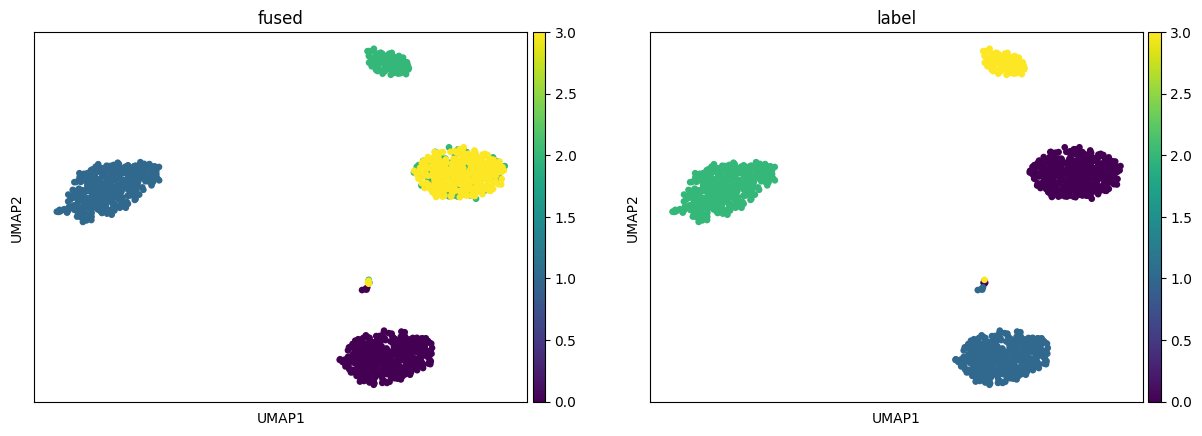

In [ ]:
from scipy import io
label_all = io.loadmat('two-layer similarity\\high order\\group.mat')
label_all = label_all['group']
label_all = label_all.squeeze(-1)
from sklearn.cluster import SpectralClustering
from utils.evaluation_script import *
fused = io.loadmat('two-layer similarity\\high order\\all_similarity.mat')
fused = fused['S']
clustering = SpectralClustering(affinity='precomputed', n_clusters=4)
label_all = clustering.fit(fused).labels_
purity, acc, nmi, ari = cluster_score(all_label, label_all) 
print("purity: %.3f,NMI: %.3f.ARI: %.3f,ACC:%.3f"%(purity,nmi,ari,acc))
adata.obs['fused'] = np.array(label_all)
sc.pl.umap(adata,color=['fused','label'])

In [ ]:
from torch import nn
import torch

from SPD_DNN.spd import SPDTransform, SPDRectified, SPDNormalization

class MSNet(nn.Module):
    def __init__(self):
        super(MSNet, self).__init__()
        self.layers = nn.Sequential(
            SPDNormalization(32),
            SPDTransform(32, 28, 1),
            # SPDNormalization(28),
            SPDRectified(),

            SPDTransform(28, 20, 1),
            # SPDNormalization(20),
            SPDRectified(),

            SPDTransform(20, 16, 1),
            # SPDNormalization(16),
            SPDRectified(),

            SPDTransform(16, 8, 1),
            # SPDNormalization(8),
            SPDRectified(),

            SPDTransform(8, 4, 1),
            # SPDNormalization(4),
            SPDRectified(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x



In [ ]:
# 无监督

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from pytorch_metric_learning import losses, miners,reducers,distances


training_labels = np.array(label_all)
training_labels  = torch.from_numpy(training_labels)
data = torch.tensor(all_data).to(torch.float)
batch_size = 256
train_set = torch.utils.data.TensorDataset(data, training_labels)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0,shuffle=True)
distance=distances.LpDistance(p=2,normalize_embeddings=False) # use euclidean distance

reducer = reducers.ThresholdReducer(low = 0)
margin = 2.2
triplet_type = 'hard'
loss_func = losses.TripletMarginLoss(margin = margin, distance = distance, reducer = reducer)
            #Define miner_function,自动选择困难三元组
mining_func = miners.TripletMarginMiner(margin = margin, distance = distance,type_of_triplets = triplet_type)
import torch.nn.functional as F
from torch import nn
from torch.optim import AdamW,SGD
from SPD_DNN.optimizer import StiefelMetaOptimizer
from pytorchtools import EarlyStopping
lr=0.00001
lr = 1e-10
lr=0.005
for i in range(1):
    training_labels = np.array(label_all)
    training_labels  = torch.from_numpy(training_labels)
    data = torch.tensor(all_data).to(torch.float)
    batch_size = 256
    train_set = torch.utils.data.TensorDataset(data, training_labels)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0,shuffle=True)
    distance=distances.LpDistance(p=2,normalize_embeddings=False) # use euclidean distance
    model = MSNet()
    optimizer = AdamW(model.parameters(), lr=lr)
    optimizer = StiefelMetaOptimizer(optimizer)
    device = 'cuda:0'
    model = model.to(device)
    epochs = 500
    flag_epoch = 0
    mined_epoch_triplet=np.array([])#
    early_stopping = EarlyStopping(patience=5, delta=50,verbose=True)

    for epoch in range(epochs):
        total_loss = 0
        temp_num_triplet=0
        for batch_idx, (train_data, training_labels) in enumerate(train_loader):

            train_data, training_labels = train_data.to(device), training_labels.to(device)
            optimizer.zero_grad()
            embeddings = model(train_data)
            embeddings = log_SPD(embeddings)
            embeddings = embeddings.reshape(embeddings.shape[0],embeddings.shape[-1]*embeddings.shape[-2])
            indices_tuple = mining_func(embeddings, training_labels)
            temp_num_triplet=temp_num_triplet+indices_tuple[0].size(0)
            loss = loss_func(embeddings, training_labels, indices_tuple)
            total_loss +=loss
            loss.backward()
            optimizer.step() 
        # mined_epoch_triplet=np.append(mined_epoch_triplet,temp_num_triplet)
        print("epoch={},number_hard_triplet={}".format(epoch,temp_num_triplet))
        early_stopping(temp_num_triplet, model)#
        if temp_num_triplet==0:
            break
        if early_stopping.early_stop:
            print("Early stopping")
            break
    training_labels = np.array(all_label)
    training_labels  = torch.from_numpy(training_labels)
    batch_list = np.array([int(i) for i in batch_list])
    batch_list_tensor  = torch.from_numpy(batch_list)
    batch_size = 32
    data = torch.tensor(all_data).to(torch.float)
    train_set = torch.utils.data.TensorDataset(data, training_labels,batch_list_tensor)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0,shuffle=True)
    device = 'cpu'
    model = model.to( device)
    num = 0
    features = []
    labels = []
    b_list = []
    if 1:
        for batch_idx, (train_data, training_labels,batch) in enumerate(train_loader):
            model.train()
            embeddings = model(train_data)        
            features.append(embeddings.detach())
            labels.append(training_labels)
            b_list.append(batch)
    features=torch.cat(features)
    labels = torch.cat(labels)
    b_list = torch.cat(b_list)
    features = log_SPD(features)
    import anndata
    import scanpy as sc
    # test_data = test_data.reshape(len(test_data),100)
    # 创建一个空的AnnData对象
    # log_feature = log_feature.numpy()
    diagMatrix = features.reshape((len(features),-1))
    adata_after = anndata.AnnData(diagMatrix.numpy())
    # 创建观测（样本）和变量（特征）的名称列表
    obs_names = [str(i) for i in range(len(diagMatrix))]
    var_names = [str(i) for i in range(diagMatrix.shape[1])]
    # 创建一个随机的观测-变量矩阵
    X = np.random.rand(len(obs_names), len(var_names))
    # 将观测-变量矩阵和名称列表分配给AnnData对象
    adata_after.obs_names = obs_names
    adata_after.var_names = var_names
    import pandas as pd
    obs_annotation = pd.DataFrame({'label':labels, 'batch':b_list})
    adata_after.obs = obs_annotation
    adata_after.filename = 'simulated_1_' + str(i) +'.h5ad'
    # print(total_loss)

c:\Users\admin\.conda\envs\ljw\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
c:\Users\admin\.conda\envs\ljw\lib\site-packages\ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\admin\Desktop\postgraduate\matlab toolbox\simtb-master\simulated_data\PT\parallel_transport.py:40: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).m

epoch=0,number_hard_triplet=1992918
Validation loss decreased (inf --> 1992918.000000).  Saving model ...
epoch=1,number_hard_triplet=309188
Validation loss decreased (1992918.000000 --> 309188.000000).  Saving model ...
epoch=2,number_hard_triplet=255338
Validation loss decreased (309188.000000 --> 255338.000000).  Saving model ...
epoch=3,number_hard_triplet=265264
epoch=4,number_hard_triplet=268578
epoch=5,number_hard_triplet=234555
Validation loss decreased (255338.000000 --> 234555.000000).  Saving model ...
epoch=6,number_hard_triplet=234296
Validation loss decreased (234555.000000 --> 234296.000000).  Saving model ...
epoch=7,number_hard_triplet=236810
epoch=8,number_hard_triplet=282328
epoch=9,number_hard_triplet=270921
epoch=10,number_hard_triplet=236616
epoch=11,number_hard_triplet=250563
Early stopping


c:\Users\admin\.conda\envs\ljw\lib\site-packages\ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\admin\.conda\envs\ljw\lib\site-packages\anndata\_io\h5ad.py:48: FutureWarning: The `force_dense` argument is deprecated. Use `as_dense` instead.
  FutureWarning,


epoch=0,number_hard_triplet=2728270
Validation loss decreased (inf --> 2728270.000000).  Saving model ...
epoch=1,number_hard_triplet=344471
Validation loss decreased (2728270.000000 --> 344471.000000).  Saving model ...
epoch=2,number_hard_triplet=298188
Validation loss decreased (344471.000000 --> 298188.000000).  Saving model ...
epoch=3,number_hard_triplet=271279
Validation loss decreased (298188.000000 --> 271279.000000).  Saving model ...
epoch=4,number_hard_triplet=240375
Validation loss decreased (271279.000000 --> 240375.000000).  Saving model ...
epoch=5,number_hard_triplet=252826
epoch=6,number_hard_triplet=263513
epoch=7,number_hard_triplet=238347
Validation loss decreased (240375.000000 --> 238347.000000).  Saving model ...
epoch=8,number_hard_triplet=233489
Validation loss decreased (238347.000000 --> 233489.000000).  Saving model ...
epoch=9,number_hard_triplet=217602
Validation loss decreased (233489.000000 --> 217602.000000).  Saving model ...
epoch=10,number_hard_trip

c:\Users\admin\.conda\envs\ljw\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":


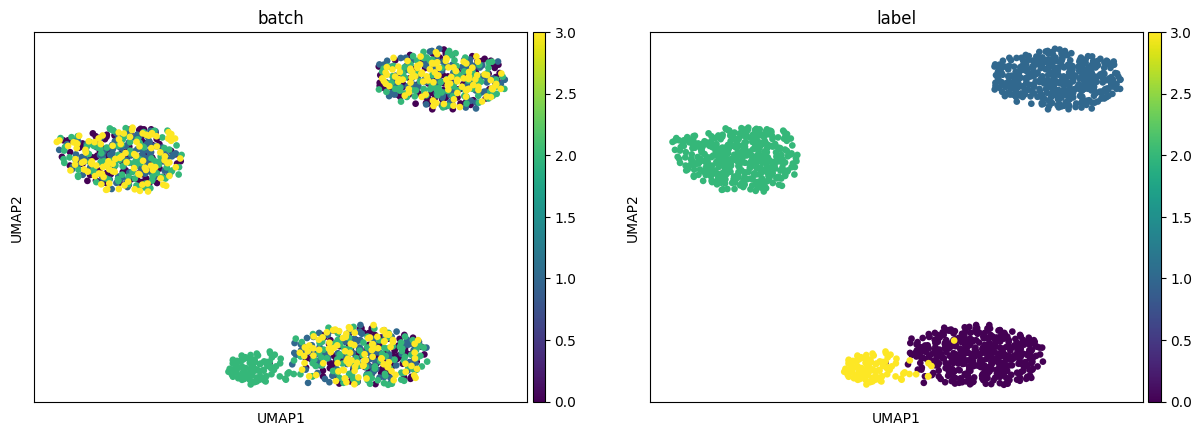

In [141]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
training_labels = np.array(all_label)
training_labels  = torch.from_numpy(training_labels)
batch_list = np.array([int(i) for i in batch_list])
batch_list_tensor  = torch.from_numpy(batch_list)
batch_size = 32
data = torch.tensor(all_data).to(torch.float)
train_set = torch.utils.data.TensorDataset(data, training_labels,batch_list_tensor)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0,shuffle=True)
device = 'cpu'
model = model.to( device)
num = 0
features = []
labels = []
b_list = []
if 1:
    for batch_idx, (train_data, training_labels,batch) in enumerate(train_loader):
        model.train()
        embeddings = model(train_data)        
        features.append(embeddings.detach())
        labels.append(training_labels)
        b_list.append(batch)
features=torch.cat(features)
labels = torch.cat(labels)
b_list = torch.cat(b_list)
features = log_SPD(features)
import anndata
import scanpy as sc
# test_data = test_data.reshape(len(test_data),100)
# 创建一个空的AnnData对象
# log_feature = log_feature.numpy()
diagMatrix = features.reshape((len(features),-1))
adata_after = anndata.AnnData(diagMatrix.numpy())
# 创建观测（样本）和变量（特征）的名称列表
obs_names = [str(i) for i in range(len(diagMatrix))]
var_names = [str(i) for i in range(diagMatrix.shape[1])]
# 创建一个随机的观测-变量矩阵
X = np.random.rand(len(obs_names), len(var_names))
# 将观测-变量矩阵和名称列表分配给AnnData对象
adata_after.obs_names = obs_names
adata_after.var_names = var_names
import pandas as pd
obs_annotation = pd.DataFrame({'label':labels, 'batch':b_list})
adata_after.obs = obs_annotation
# adata_after.obs['batch']=[str(i) for i in batch_list]
sc.tl.pca(adata_after)
sc.pp.neighbors(adata_after,use_rep='X_pca')
sc.tl.umap(adata_after)
sc.pl.umap(adata_after,color=['batch','label'])

In [ ]:
from sklearn.cluster import SpectralClustering
from utils.evaluation_script import cluster_score 
clustering = SpectralClustering(n_clusters=4)
labels_pred = clustering.fit(adata_after.obs['X_umap']).labels_
# all_label = [label.strip('Group') for label in adata.obs['label']]
purity,_,nmi,ari = cluster_score(adata_after.obs['label'],labels_pred)
print("Purity:%.3f,ARI:%.3f,nmi:%.3f"%(purity,ari,nmi))

Purity:0.999,ARI:0.608,nmi:0.800
